# Variational Autoencoder
Implementation based on the following papers:
- [Auto Encoding Varational Bayes](https://arxiv.org/abs/1312.6114)
- [Variational Autoencoder for Deep Learning of Images, Labels and Captions](https://papers.nips.cc/paper/6528-variational-autoencoder-for-deep-learning-of-images-labels-and-captions.pdf)



## 1. Import dependencies
Import the modules neccessary to run the project. If you get a 
``` 
Error: Module not found
```
run the following code in a separate cell 
``` 
!pip install -r requirements.txt 

```

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

Check if a CUDA GPU is available, and if yes use it. Else use the CPU for computations.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using %s for computation" % device)

Using cuda for computation


In [0]:
project_dir = 'VAE/'
dataset_dir = project_dir + 'datasets/'
images_dir = project_dir + 'images/'
model_dir = project_dir + 'model/'

## 2. Tune Hyperparameters
Set up the hyperparameters for the model. If you get any errors about running out of memeory, try reducing the batch size. 

The latent size is the size of the encoding vector that the Encoder finally produces. Increasing this value can improve performance, but there are diminishing returns once you cross a certain limit.

In [0]:
batch_size = 32           # number of inputs in each batch
epochs = 10               # times to run the model on complete data
image_size = 32
hidden_size = 1024        # hidden dimension
latent_size = 32          # latent vector dimension
lr = 1e-3                 # learning rate
train_loss = []

# If you want to use the Vanilla VAE, uncomment the following block
# image_size = 28
# input_size = image_size ** 2  # size of each input
# hidden_size = 300  # hidden dimension
# latent_size = 45  # latent vector dimension

## 3. Load Data and DataLoader
The SVHN and the FashionMNIST dataset are used here, however it can easily be replaced with another dataset by calling the appropriate function. Examples being
```
dataset.MNIST(dataset_dir, train=True)
```
Check the [docs](https://pytorch.org/docs/stable/torchvision/datasets.html) for more information about the datasets available to easily download using PyTorch. Or load your own dataset.

In [6]:
train_data = datasets.SVHN(dataset_dir + 'SVHN/', split='train', download=True, transform=transforms.Compose([transforms.Resize(64),transforms.ToTensor()]))
test_data = datasets.SVHN(dataset_dir + 'SVHN/', split='test', download=True, transform=transforms.Compose([transforms.Resize(64),transforms.ToTensor()]))
# For VAE
# train_data = datasets.FashionMNIST(
#     dataset_dir, train=True, download=True, transform=transforms.ToTensor()
# )
# test_data = datasets.FashionMNIST(
#     dataset_dir, train=False, download=True, transform=transforms.ToTensor()

Using downloaded and verified file: /content/gdrive/My Drive/fastai-v3/datasets/SVHN/train_32x32.mat
Using downloaded and verified file: /content/gdrive/My Drive/fastai-v3/datasets/SVHN/test_32x32.mat


In [0]:
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

Utility function to help 
*   Display images from the tensor.
*   Flatten the image into a 1-D tensor.
*   Take a 1-D tensor and convert it back into a image.

In [0]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images)

def show_image(img):
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.show()

Next we will have a look at the data we will be working with.

tensor([1, 1, 0, 2, 2, 6, 1, 7, 4, 0, 1, 6, 3, 4, 3, 2, 1, 0, 1, 8, 1, 2, 7, 1,
        7, 1, 6, 9, 0, 5, 1, 4])


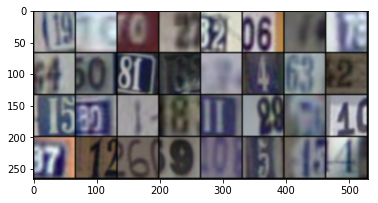

In [36]:
trial = next(iter(trainloader))
images, labels = trial
print(labels)
show_images(images)

## 4. Define the Model Architecture
The VAE consists of an encoder that takes the images outputs 2 vectors of length `latent_size`. 

Traditionally, one is the vector of `means`, μ, and another is the vector of `standard deviations`, σ.

In this case however, to prevent the model from learning negative values of variance, we instead create a vector containing the `log(variance)`.

This gives us a collection of random variables ***X***, from which we sample to provide inputs to the Fully Connected layer using the `sample` function. 

The next part is the decoder which tries to reconstruct the image from the vector. 

The Adam optimiser is used here.

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encodinglayer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU()
        )
        self.encodinglayer2_mean = nn.Sequential(nn.Linear(hidden_size, latent_size))
        self.encodinglayer2_logvar = nn.Sequential(nn.Linear(hidden_size, latent_size))
        self.decodinglayer = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid(),
        )

    def sample(self, log_var, mean):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.encodinglayer1(x)
        log_var = self.encodinglayer2_logvar(x)
        mean = self.encodinglayer2_mean(x)

        z = self.sample(log_var, mean)
        x = self.decodinglayer(z)

        return x, mean, log_var

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), 1024, 1, 1)

In [0]:
class DCVAE(nn.Module):
  def __init__(self, image_channels=3, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size):
    super(VAE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(image_channels, 32, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 4, 2),
        nn.LeakyReLU(0.2),
        Flatten(),
    )
    self.encoder_mean = nn.Linear(hidden_size, latent_size)
    self.encoder_logvar = nn.Linear(hidden_size, latent_size)
    self.fc = nn.Linear(latent_size, hidden_size)
    self.decoder = nn.Sequential(
                                UnFlatten(),
                                nn.ConvTranspose2d(hidden_size, 128, 5, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(128, 64, 5, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(64, 32, 6, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(32, image_channels, 6, 2),
                                nn.Sigmoid()   
                              )
  
  def sample(self, log_var, mean):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mean)
  
  def forward(self, x):
    x = self.encoder(x)
    log_var = self.encoder_logvar(x)
    mean = self.encoder_mean(x)
    z = self.sample(log_var, mean)
    x = self.fc(z)
    x = self.decoder(x)

    return x, mean, log_var

In [ ]:
vae = DCVAE().to(device)
# vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

### Load pretrained weights
Comment this out if you want to train from scratch.

In [12]:
vae.load_state_dict(torch.load(model_dir+"DCVAE.pt"))
# vae.load_state_dict(torch.load(model_dir+"VAE.pt"))

<All keys matched successfully>

## 5. Training the model
Set the model to the training mode first. 

Things to note, two types of loss are used here. The first one is just the reconstruction loss that compares the recontructed images to the original one using Binary Cross Entropy. 

The second one is called the [Kullback–Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) which gives a measure of how much a distibution diverges from another. We use this to force the encodings to distribute themselves around the centre of the latent space.

In [0]:
vae.train()

for epoch in range(epochs):
  for i, (images, _) in enumerate(trainloader):
    images = images.to(device)
    optimizer.zero_grad()
    reconstructed_image, mean, log_var = vae(images)
    CE = F.binary_cross_entropy(reconstructed_image, images, reduction='sum')
    # for VAE
    # CE = F.binary_cross_entropy(
    #             reconstructed_image, images.view(-1, input_size), reduction="sum"
    #         )
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    loss = CE + KLD
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    if(i % 100 == 0):
      print("Loss:")
      print(loss.item() / len(images))

Loss:
7780.10498046875
Loss:
7789.4912109375
Loss:
7748.111328125
Loss:
7599.47900390625
Loss:
7577.810546875
Loss:
7362.97607421875
Loss:
7324.45263671875
Loss:
7431.3779296875
Loss:
7477.2138671875
Loss:
7556.4462890625
Loss:
7559.572265625
Loss:
7804.791015625
Loss:
7455.1025390625
Loss:
7498.6796875
Loss:
7720.29736328125
Loss:
7524.9501953125
Loss:
7543.49658203125
Loss:
7645.08544921875
Loss:
7363.5703125
Loss:
7521.892578125
Loss:
7564.58154296875
Loss:
7680.671875
Loss:
7697.8330078125
Loss:
7767.47802734375
Loss:
7540.95263671875
Loss:
7523.97607421875
Loss:
7289.39990234375
Loss:
7778.8662109375
Loss:
7373.013671875
Loss:
7353.27294921875
Loss:
7904.7470703125
Loss:
7655.83984375
Loss:
7810.23876953125
Loss:
7542.82666015625
Loss:
7275.19873046875
Loss:
7736.08740234375
Loss:
7508.3916015625
Loss:
7616.77099609375
Loss:
7517.77978515625
Loss:
7319.6025390625
Loss:
7474.236328125
Loss:
7564.94482421875
Loss:
7663.00537109375
Loss:
7691.6904296875
Loss:
7593.88720703125
Loss:
7

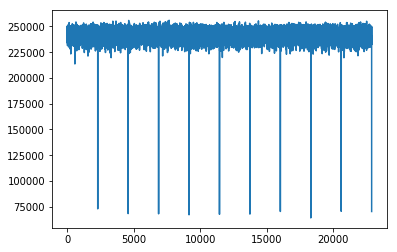

In [0]:
plt.plot(train_loss)
plt.show()

## 6. Evaluate performance on the test set
Set the model to the evaluation mode. This is important otherwise you will get inconsistent results.

We save the mean vectors and the labels in a separate list to visualise them later.

As we can see, the model has learnt to reconstruct the images pretty well. We can improve performance by training for longer or by increasing the latent vector size to encode more information.

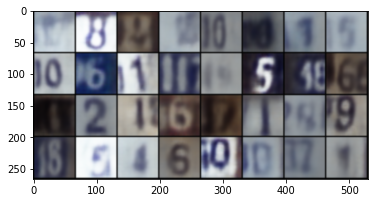

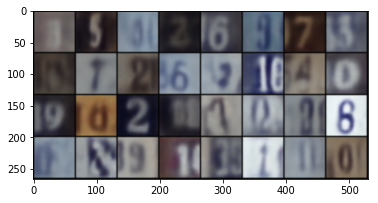

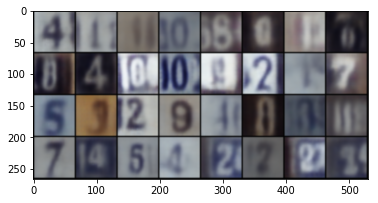

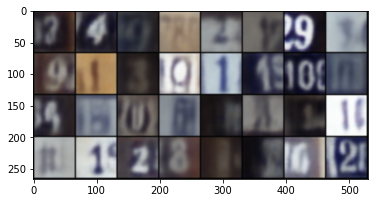

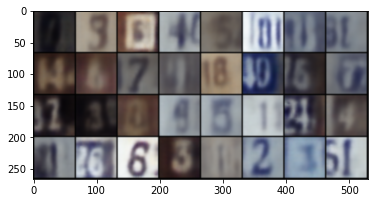

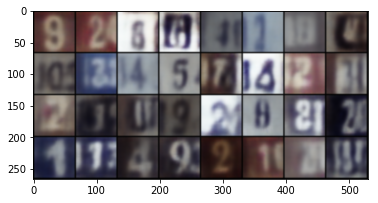

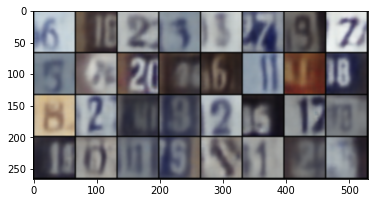

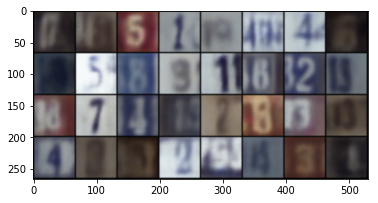

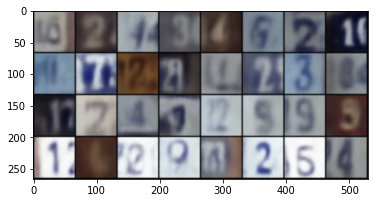

In [39]:
vae.eval()
vectors = []
with torch.no_grad():
  for i, (images, labels) in enumerate(testloader):
    images = images.to(device)
    reconstructed_image, mean, log_var = vae(images)
    reconstructed_image = reconstructed_image.view(-1, 1, image_size, image_size)
    temp = list(zip(labels.tolist(), mean.tolist()))
    for x in temp:
      vectors.append(x)
    if(i%100 == 0):
      show_images(reconstructed_image.cpu())
      img_name = images_dir + "evaluation/DCVAE/" + str(i).zfill(3)
      # img_name = images_dir + "evaluation/VAE/" + str(i).zfill(3)
      plt.savefig(img_name)
      plt.show()

## 7. Generate images from latent vectors
Here I have taken three vectors and I'll interpolate between them to show how the continuos latent space in a VAE allows you to smoothly tranistion between different types of images.

This code is for the DCVAE.


In [0]:
vae.eval()
start = np.array([-1.8611,  0.3629, -0.1625,  0.6801,  1.2033,  1.0312,  0.5436,  1.3066,
         0.2905,  0.1377,  0.5122, -0.1663,  2.3431, -0.0896, -0.5873, -1.4804,
         0.8141, -1.2197,  0.0484,  0.6414, -0.8172, -0.9543, -0.8818, -1.1465,
         0.2720,  1.1792,  1.8410, -0.4715,  1.4380,  0.5139,  1.2099, -0.5012])
middle = np.array([-0.4763, -0.4644, -0.3850,  0.6598,  0.9110,  0.4451,  0.4617, -0.0526,
         0.2808,  0.6080,  0.5532, -1.5506, -0.5199,  0.1359,  0.0373,  0.4284,
        -0.4134, -1.7078, -0.0309, -1.0195, -0.3151, -0.5569,  0.2832, -0.9132,
        -1.1339, -1.3196,  2.1297,  0.8122,  0.6849, -0.6710, -0.3507, -0.9001])
end = np.array([-1.6239,  0.2496, -1.0690, -0.8745,  0.4133,  2.2452, -0.2385, -0.6532,
         0.3818, -0.9425,  0.9404,  1.3901, -0.3327, -0.3719, -0.0365,  0.3240,
         0.4928, -0.4988, -1.2228, -0.1638,  0.6093, -0.5264, -1.6963, -0.3718,
         2.1971,  0.2166, -0.0821, -0.1722, -0.1896, -1.6610, -0.1497,  1.0655])
points = 50
linfit = interpolate.interp1d([1, points/2, points], np.vstack([start, middle, end]), axis=0)
with torch.no_grad():
  for i in range(2, points-1):
    z = linfit(i)
    z = torch.FloatTensor(z)
    print(z.shape)
    z = z.reshape((-1, 32))
    z = z.to(device)
    z = vae.fc(z)
    generated_images = vae.decoder(z)
    generated_images = generated_images.view(-1, 64, 64)
    img = generated_images[0].cpu()
    plt.imshow(img)
    img_name = images_dir + 'interpolate/' + str(i).zfill(3)
    plt.savefig(img_name)
    plt.show()


## 8. Visualise the latent representations of the images
Using Singular Value Decomposition, we perform Principal Component Analysis to visualise the two largest eigenvalues. Then we add the labels for each element and create a dataframe.

In [18]:
labels, z_vectors = list(zip(*vectors))
z_vectors = torch.tensor(z_vectors)
U, S, V = torch.svd(torch.t(z_vectors))
C = torch.mm(z_vectors, U[:, :2]).tolist()
C = [x + [labels[i]] for i, x in enumerate(C)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df = pd.DataFrame(C, columns=['x', 'y', 'label']) 
df.head()

,x,y,label
0,-2.153874,-2.298586,3
1,3.375610,-2.676195,1
2,-0.851677,0.685897,2
3,1.400374,1.521139,9
4,-2.679109,-1.818430,2


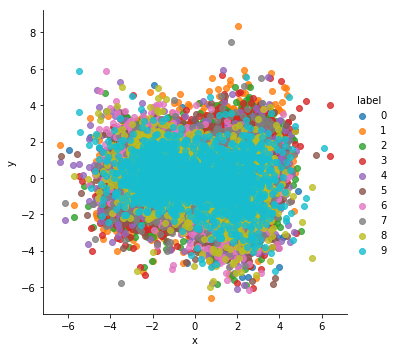

In [34]:
sns.lmplot( x="x", y="y", data=df, fit_reg=False, hue='label')

## 9. Saving the model
Save the model incase we need to load it again.

In [0]:
torch.save(vae.state_dict(), model_dir+"DCVAE.pt")
# Use this for saving the VAE model
# torch.save(vae.state_dict(), model_dir + "VAE.pt")